In [37]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Length based data

In [38]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################

inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0

n_data = output.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_loss = -np.dot(xx_mask, output) * L_x/N_s




In [39]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :]
A[:, 2] = inputPara[5, :]
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   5993.73724467   -8682.17376047    2475.9614333   -48534.09494157
 1114448.7126439 ]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.12406422986004143

In [40]:
output_loss.shape

(1000,)

In [41]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :] - inputPara[2, :]/2.0
A[:, 2] = inputPara[5, :] - inputPara[2, :]/2.0
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   2890.63108109   -8682.17376047    2475.9614333   -48534.09494157
 1114448.7126439 ]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.12406422986004143

In [42]:
# fno model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

print(count_params(model))
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

ntrain = n_data
x_train = input.to(device).reshape(ntrain, N_s, 2)
pred = np.zeros((n_data, N_s))
for i in range(n_data):
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:]).squeeze(), min=0.0).detach().cpu().numpy()
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:].to(device)), min=0.0).detach().cpu().numpy().flatten()
    # pred[i, :] = torch.abs(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    pred[i, :] = torch.exp(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    
    
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
fno_loss = -np.dot(pred, xx_mask) * L_x/N_s

print("FNO mean loss error: ",  np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )
print("FNO max loss error: ",  np.max(  np.abs(fno_loss - output_loss) / output_loss  ) )



1336001
FNO mean loss error:  0.013537512354415792
FNO max loss error:  0.11912474868594314


In [43]:
fno_loss_min_ind = np.argmin(fno_loss)
print("fno min = ", fno_loss[fno_loss_min_ind], " at ", fno_loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, fno_loss_min_ind])
print("truth eval = ", output_loss[fno_loss_min_ind])
print("error = ", np.abs((fno_loss[fno_loss_min_ind] - output_loss[fno_loss_min_ind])/output_loss[fno_loss_min_ind]))

loss_min_ind = np.argmin(output_loss)
print("truth min = ", output_loss[loss_min_ind], " at ", loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, loss_min_ind])
print("fno eval = ", fno_loss[loss_min_ind])
print("error = ", np.abs((fno_loss[loss_min_ind] - output_loss[loss_min_ind])/output_loss[loss_min_ind]))


fno min =  262338.70631641813  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
truth eval =  262913.03325813607
error =  0.0021844749748638295
truth min =  262913.03325813607  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
fno eval =  262338.70631641813
error =  0.0021844749748638295


262338.70631641813


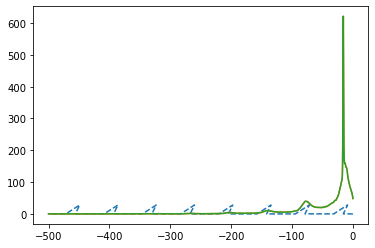

In [44]:
# L_p, x2, x3, h
# fix L_p, h
sample, uf, L_p, x1, x2, x3, h = inputPara[:, fno_loss_min_ind]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

X_Y = x_train[fno_loss_min_ind:fno_loss_min_ind+1,:,:]
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = -np.dot(out, xx_mask)* L_x/N_s
plt.plot(xx_mask, out)
plt.plot(xx_mask, out)
print(loss)

In [45]:
# L_p, x2, x3, h
# fix L_p, h
L_p, h = 61.0,  30.0
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
x2_range = np.linspace(-L_p, 0.0, nx2)
x3_range = np.linspace(-L_p/2+15, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
                
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        

(-30.0, 0.0)

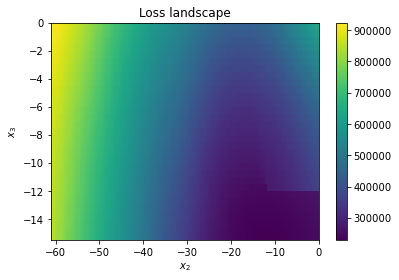

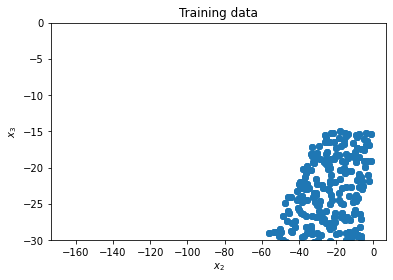

In [46]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.pcolormesh(X, Y, loss.transpose())
plt.colorbar()
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Loss landscape")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.ylim([-30, 0])

In [47]:
# L_p, x2, x3, h
# fix L_p, h

x3, h = -15.5,  30.0
x3, h =  torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
Lp_range = np.linspace(61, 249, 188*2 + 1)
x2_range = np.linspace(-249, 0, 249*2 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(Lp_range)))
for i in range(len(x2_range)):
    for j in range(len(Lp_range)):
        if Lp_range[j] + x2_range[i] < 0.0:
            loss[i,j] = np.NaN
        else:
            x2, Lp = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(Lp_range[j], dtype=torch.float)
            X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

            out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
            loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
        
        

Text(0.5, 1.0, 'Training data')

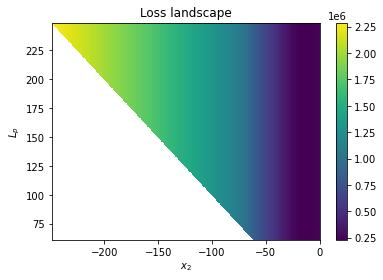

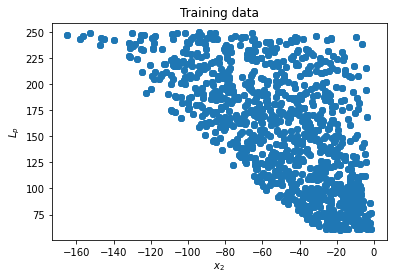

In [48]:
X, Y = np.meshgrid(x2_range ,Lp_range)
plt.pcolormesh(X, Y, loss.transpose())
plt.colorbar()
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Loss landscape")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Training data")
# plt.ylim([-30, 0])

sum =  2799.364882352539
dx2_x1 =  5  loss =  255175.6075719778
sum =  2289.896807639795
dx2_x1 =  10  loss =  227980.44721974965
sum =  2039.2285318814027
dx2_x1 =  15  loss =  213658.09801476402
sum =  1945.2794734523154
dx2_x1 =  20  loss =  214384.4063785294
sum =  2195.1462626454722
dx2_x1 =  25  loss =  234873.56951246053
sum =  2367.489784163824
dx2_x1 =  28  loss =  256646.07476506257
sum =  2528.150900401163
dx2_x1 =  30  loss =  268334.41000783106


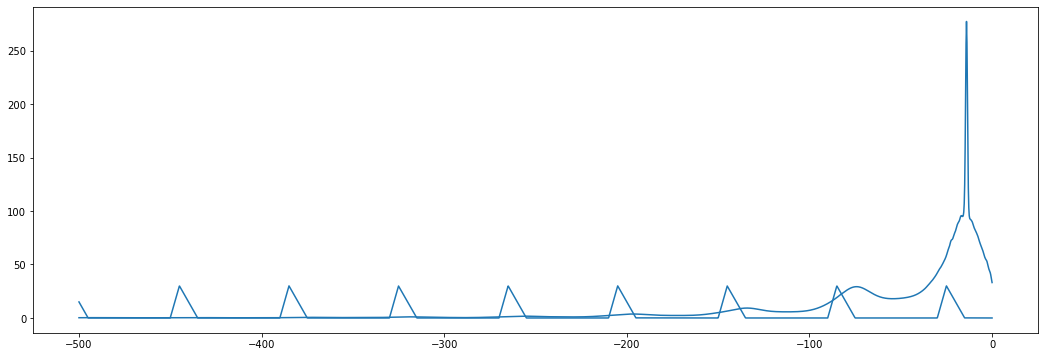

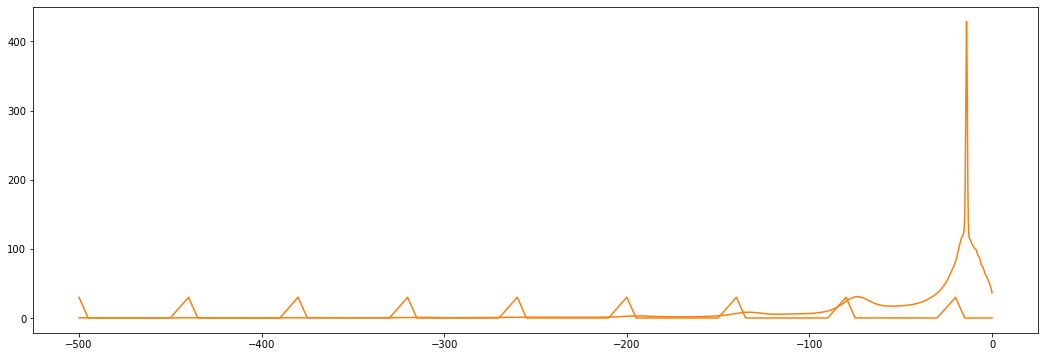

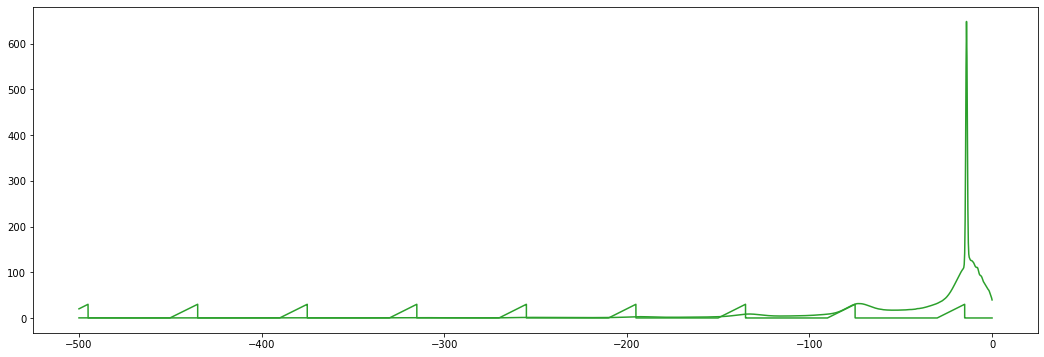

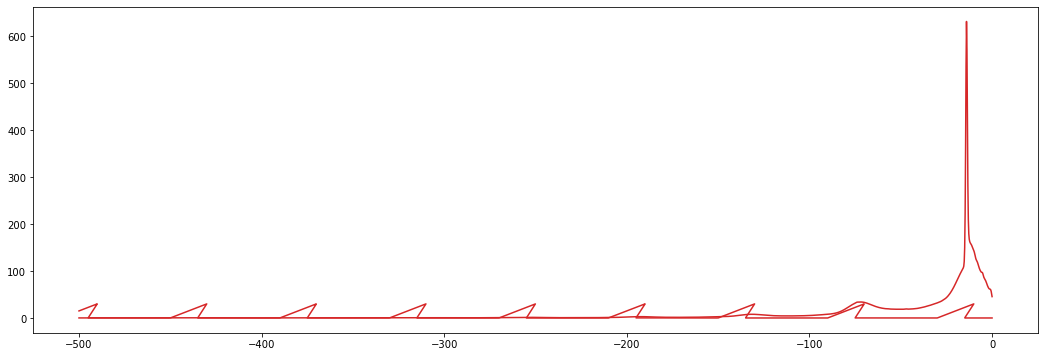

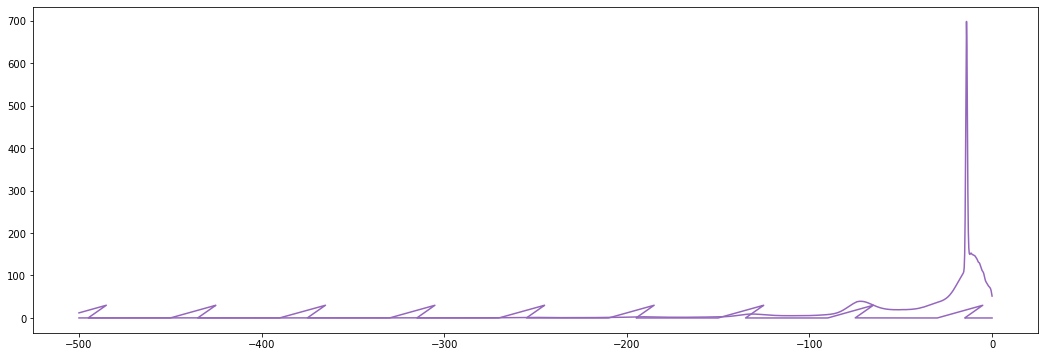

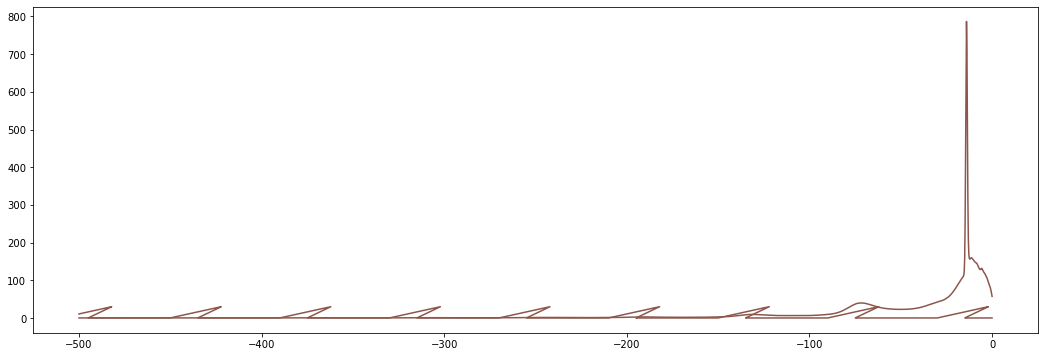

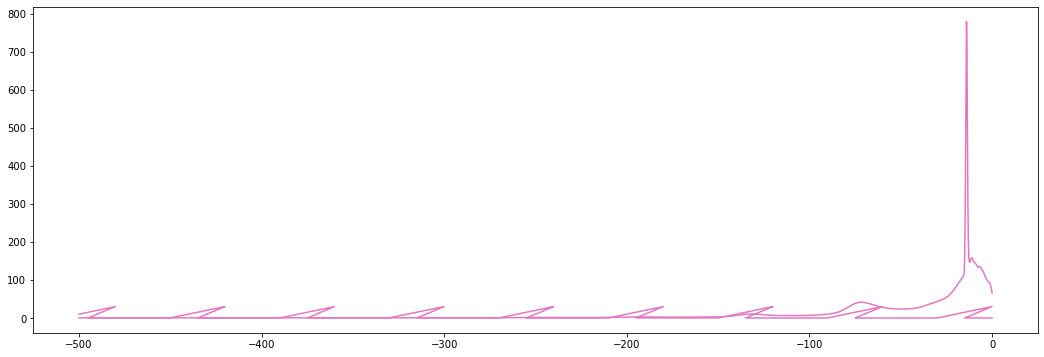

In [11]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/optimizedtests0906/"

# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 500
L_p, x1, x3, h = 60.0, -30.0, -15, 30.0
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
dx2_x1_list = np.array([5, 10, 15, 20, 25, 28, 30])
true_loss = np.zeros(len(dx2_x1_list))
x_mesh, y_mesh = np.zeros((len(dx2_x1_list), N_s)), np.zeros((len(dx2_x1_list), N_s))
density_1d_data_all = np.zeros((len(dx2_x1_list), N_s, 3))
density_1d_data = np.zeros((len(dx2_x1_list), N_s))
for i in range(len(dx2_x1_list)):
    dx2_x1 = dx2_x1_list[i]
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x1+dx2_x1, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/x2_"+str(dx2_x1)+"_U020uf*")
    for file_name in file_names:
        
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)
    print("sum = ", sum(density_1d_data[i, 0:1600]))
    true_loss[i] = -np.dot(density_1d_data[i, :], xx)* L_x/N_s
    
    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))


loss =  [919116.66829993 898328.39676221 877675.06899788 857590.3575927
 838102.80328187 818607.45564114 798759.12724433 778603.19865648
 758290.64777212 738445.12034708 719255.80092783 700113.05345975
 680860.85694344 661731.67472962 642509.92826029 623039.01689216
 603719.47311744 584908.23944073 566631.93396829 548654.19214107
 530437.31181116 511145.09307628 490928.23903345 471082.80312575
 452051.73400146 434066.35790739 417680.00904254 402512.81410859
 388261.62285457 375043.04332104 361949.68675066 348521.65997347
 335073.82606986 321777.20950067 308732.71638516 296121.86859614
 284121.65604263 273256.40305419 263986.07503868 255736.31590438
 248244.25693874 241464.67648347 235817.7792863  231471.27156011
 228175.50122638 225602.85192604 223807.81075768 222794.05150526
 222458.30525371 222583.26519662 223073.59238812 223869.44811056
 225261.60442472 227223.12432096 229415.71000156 231892.61989268
 234525.83841463 237139.98690444 239521.48959602 241699.02926947
 243861.74877924]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [884153.32689917 864595.38009366 845324.03108057 825975.5585642
 806840.34173457 787636.83757916 768034.68014204 748445.91588106
 729146.19185124 710675.55378279 692901.27439434 675477.75026379
 658301.44369452 641210.85711764 623957.04650534 606636.05576722
 589613.84827625 573250.88304244 557125.72065319 540584.99866596
 522967.72299669 504019.46528986 484643.70294048 465889.34861683
 447939.96818411 430935.089441   415066.31512044 400304.98669909
 386762.45537741 373555.58645577 360156.03759776 346201.12772591
 332345.0377597  318829.73825306 305700.44512931 293227.19402169
 281664.03637787 271839.86346327 263437.25834083 255778.59463667
 249051.46609584 243331.99793297 238779.82302237 235312.96284377
 232783.47097503 230828.73425786 229376.3048038  228592.22642625
 228309.18290291 228498.95840737 229175.36548898 230247.86735509
 231682.55279764 233300.24440357 235161.80437074 237339.41489176
 239664.3996554  241977.83670104 244153.17577521 246206.07858791
 248167.9932384 ]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [850446.7103183  832523.24444257 814758.38656136 796556.09617168
 778148.75689461 759656.95211058 741157.75311908 722861.38161223
 705072.5743778  688056.59072792 671667.74866449 655631.03795102
 639961.85748743 624232.47646347 608564.2673526  592746.39723067
 576678.36289859 561065.82624636 545649.33966843 529430.26540886
 512194.87318046 494225.28510711 476001.15139966 458399.41407312
 441548.97765706 425488.87436311 410347.59669722 396243.65035612
 382905.49151932 369680.45417383 355735.55954612 341652.30977499
 327656.84272146 313881.37023153 300596.84196015 287997.94568426
 276955.81272757 267959.29920194 259936.14974472 252905.2792307
 247101.37849827 242422.79095361 238792.16064648 236071.41505411
 233873.6206392  232196.24851173 231053.65615088 230490.69816821
 230406.99320774 230668.66967604 231286.028408   232389.11317108
 233955.79032552 235708.56139843 237635.6710962  239809.80932485
 242211.01651824 244714.75003796 247205.61807542 249586.05158141
 251884.77390558]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [819953.21659493 803417.89913008 786637.67207356 769220.3237116
 751782.50365869 734486.04293011 717346.74071841 700473.290178
 683903.24930313 667516.77711821 651353.26950938 635573.9522883
 620300.19112957 605233.69957167 590058.68500374 574395.81624063
 558766.2681512  544088.46679361 529462.87757843 514232.47259409
 498312.62456175 481760.53026224 465008.47886778 448389.82564967
 432284.73901673 416665.0722292  401554.55377963 387243.11782804
 373051.08825381 358517.18114493 343731.48571062 328629.94617808
 313511.25498073 298600.11477568 284667.24166667 272630.64328113
 263182.04970949 255197.98787162 248421.4928784  243033.85369385
 239086.85680309 236491.5777591  235574.33709756 238897.72522317
 247670.99110091 252784.69587626 256922.23082546 261723.27230175
 267665.92009982 274711.46571637 282440.49489133 290789.05734354
 299586.82694087 308864.140188   318535.67476535 328339.16832796
 338180.54957417 347915.81419108 357493.17293613 366934.80039555
 376436.71875587]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [789474.07348311 772651.4684741  755665.91139672 738865.40180505
 722208.90222471 705616.64589025 688929.7420801  672136.05702243
 655765.42060427 640088.4713909  624723.1044206  609278.47202602
 593761.6701479  577813.19191018 561546.056066   545606.34916305
 530797.07439335 516323.10647781 501318.8107934  485554.28865301
 469197.93623117 452595.35298551 435883.65149677 419247.21427768
 403195.95697964 387908.50998261 373222.31904197 358263.73259273
 342172.1172325  325230.45388346 308800.21086112 293583.20794769
 279987.09166045 268649.41215269 259726.53337107 252788.59679135
 248796.63912657 245912.51400501 243547.50131768 242288.22081671
 244487.00429126 247800.96678874 252892.43917441 258706.74203433
 265170.33784965 272398.07119646 280410.45957328 289272.51521505
 298751.42351402 308506.78689444 318177.93832846 327809.76472348
 337211.31449298 346444.57027699 355584.27610366 364778.76952329
 373845.67826863 382734.82365445 391559.21430028 400493.99003767
 409371.88517503]

(200000.0, 300000.0)

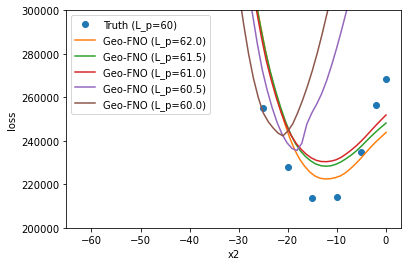

In [36]:
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

# This is for L_p = 60, x_3 = 15
ax = plt.subplot(111)
ax.plot(-L_p/2 + dx2_x1_list, true_loss,  "o", label="Truth (L_p=60)")
x3 = -15
# L_p, x2, x3, h
# fix L_p, h
for L_p in [62, 61.5, 61, 60.5, 60]:
    h = 30.0
    L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

    # 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
    nx2 = 60+1
    x2_range = np.linspace(-L_p, 0.0, nx2)
    x3 = torch.tensor(x3, dtype=torch.float)
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    loss = np.zeros(len(x2_range))
    for i in range(len(x2_range)):
        x2 = torch.tensor(x2_range[i], dtype=torch.float)

        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

        #out = model(X_Y).squeeze().detach().cpu().numpy()
        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()

        loss[i] = -np.dot(out, xx_mask)* L_x/N_s
        
    print("loss = ", loss)
    ax.plot(x2_range, loss, label=r"Geo-FNO (L_p=%3.1f)" %L_p)

ax.set_xlabel("x2")
ax.set_ylabel("loss")
ax.legend()
ax.set_ylim([2e5,3e5])

/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5
dx2_x1 =  30  loss =  272731.6552793368


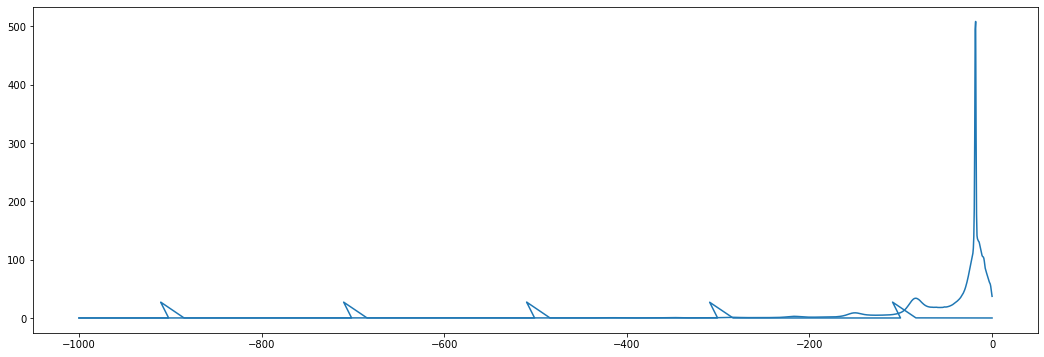

In [113]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823/"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 1000
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
samples = [633,]

x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
for i in range(len(samples)):
    L_p, x2, x3, h, press = data_info[i - 1, :]
    x1 = -0.5*L_p
    x2 = x1 + x2
    x3 = x1 + x3
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/sample"+str(samples[i])+"_U020uf*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))

# # density 
# plt.figure()
# plt.plot(xx,  density_1d_data)
# plt.plot(x_mesh, y_mesh, color="red")

# # density 
# plt.figure()
# plt.hist(x_b,  bins = 100)
# plt.plot(x_mesh, y_mesh, color="red")
